In [1]:
import numpy as np
from numpy.linalg import norm 
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.linalg
import scipy.sparse.linalg
import scipy.optimize
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.pyplot as plt
import time

In [2]:
Time = 2
L = 10
n = 128
x2 = np.linspace(-L,L,n+1)
x = x2[0:n] #periodicity
dx = x[1] - x[0]

#time
t = np.linspace(0, 2, 501)
dt = t[1] - t[0]
time_steps = int(Time/dt)

# CFL number
CFL = 2*dt/(dx**2)

L_star = CFL

In [3]:
# von-Neumann analysis
G = lambda z,l: 1+l*(8/3*np.cos(z)-1/6*np.cos(2*z)-5/2)

In [4]:
A1 = np.abs(G(1, L_star))

In [5]:
G_one = lambda z: np.abs(G(z,L_star))
opt = scipy.optimize.fminbound(lambda z:-G_one(z), -np.pi,np.pi)
A2 = G_one(opt)
print(A2)

1.0


In [6]:
e1 = np.ones(n)
A = scipy.sparse.spdiags([16*e1,-e1,-e1,16*e1,-30*e1,16*e1,-e1,-e1,16*e1],[-n+1,-n+2,-2,-1,0,1,2,n-2,n-1],n,n)
A = A/12

In [7]:
print(A.toarray())

[[-2.5         1.33333333 -0.08333333 ...  0.         -0.08333333
   1.33333333]
 [ 1.33333333 -2.5         1.33333333 ...  0.          0.
  -0.08333333]
 [-0.08333333  1.33333333 -2.5        ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -2.5         1.33333333
  -0.08333333]
 [-0.08333333  0.          0.         ...  1.33333333 -2.5
   1.33333333]
 [ 1.33333333 -0.08333333  0.         ... -0.08333333  1.33333333
  -2.5       ]]


In [8]:
A3 = np.copy(A.toarray())

In [9]:
A3.shape

(128, 128)

In [10]:
usol_fe =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_fe[:,0] = u0
u1 = u0
for j in range(time_steps):
    u2 = u1 + L_star*A@u1
    u1 = u2
    usol_fe[:,j+1] = u2

A5 = usol_fe[:, -1]

In [11]:
A5.shape

(128,)

In [12]:
G_2 = lambda z,l: (1+l*np.cos(z)-l)/(l+1-l*np.cos(z))
G_two = lambda z: np.abs(G_2(z,L_star))
opt = scipy.optimize.fminbound(lambda z:-G_two(z), -np.pi,np.pi)
A6 = G_two(opt)
print(A6)

1.0


In [13]:
e1 = np.ones(n)
B = 0.5*scipy.sparse.spdiags([-CFL*e1,-CFL*e1,2*CFL*e1,-CFL*e1,-CFL*e1],[-n+1,-1,0,1,n-1],n,n,format='csc')
B = B + scipy.sparse.eye(n)
C = 0.5*scipy.sparse.spdiags([CFL*e1,CFL*e1,-2*CFL*e1,CFL*e1,CFL*e1],[-n+1,-1,0,1,n-1],n,n,format='csc')
C = C + scipy.sparse.eye(n)

In [14]:
A7 = np.copy(B.toarray())
A8 = np.copy(C.toarray())

In [15]:
time_LU = []
PLU = scipy.sparse.linalg.splu(B)
usol_cn_1 =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_cn_1[:,0] = u0
start = time.time()
for j in range(time_steps):
    u1 = PLU.solve(C@u0)
    u0=u1
    usol_cn_1[:,j+1] = u1

end = time.time()
result = end - start
time_LU.append(result)
print(result)
A9 = usol_cn_1[:, -1]

0.023170948028564453


In [16]:
time_bicg = []
usol_cn_2 =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_cn_2[:,0] = u0
start = time.time()
for j in range(time_steps):
    u1, exit_code = scipy.sparse.linalg.bicgstab(B, C@u0)
    u0=u1
    usol_cn_2[:,j+1] = u1

end = time.time()
result = end - start
time_bicg.append(result)
print(result)
A10 = usol_cn_2[:, -1]

0.1127471923828125


In [17]:
exact_128 = np.genfromtxt('exact_128.csv', delimiter=',')
exact_256 = np.genfromtxt('exact_256.csv', delimiter=',')
exact_512 = np.genfromtxt('exact_512.csv', delimiter=',')
exact_1024 = np.genfromtxt('exact_1024.csv', delimiter=',')

In [18]:
A11 = norm(A5 - exact_128)
print(A11)

0.041134717291376646


In [19]:
A12 = norm(A9 - exact_128)
print(A12)

0.020902811351726377


In [20]:
difference = norm(A10 - exact_128)
print(difference)

0.01916692901359803


In [21]:
A5 = np.reshape(A5, (128, 1))
A9 = np.reshape(A9, (128, 1))
A10 = np.reshape(A10, (128, 1))

In [22]:
Time = 2
L = 10
n = 256
x2 = np.linspace(-L,L,n+1)
x = x2[0:n] #periodicity
dx = x[1] - x[0]

dt = L_star*(dx**2)/2
time_steps = int(Time/dt)
t = np.arange(0,Time+dt,dt)

In [23]:
e1 = np.ones(n)
A = scipy.sparse.spdiags([16*e1,-e1,-e1,16*e1,-30*e1,16*e1,-e1,-e1,16*e1],[-n+1,-n+2,-2,-1,0,1,2,n-2,n-1],n,n)
A = A/12

In [24]:
usol_fe_2 =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_fe_2[:,0] = u0
u1 = u0
for j in range(time_steps):
    u2 = u1 + L_star*A@u1
    u1 = u2

    usol_fe_2[:,j+1] = u2

sol = usol_fe_2[:, -1]
A13 = norm(sol - exact_256)
print(A13)

0.014541070458247318


In [25]:
e1 = np.ones(n)
B = 0.5*scipy.sparse.spdiags([-CFL*e1,-CFL*e1,2*CFL*e1,-CFL*e1,-CFL*e1],[-n+1,-1,0,1,n-1],n,n,format='csc')
B = B + scipy.sparse.eye(n)
C = 0.5*scipy.sparse.spdiags([CFL*e1,CFL*e1,-2*CFL*e1,CFL*e1,CFL*e1],[-n+1,-1,0,1,n-1],n,n,format='csc')
C = C + scipy.sparse.eye(n)

In [26]:
PLU = scipy.sparse.linalg.splu(B)
usol_cn_3 =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_cn_3[:,0] = u0
start = time.time()
for j in range(time_steps):
    u1 = PLU.solve(C@u0)
    u0=u1
    usol_cn_3[:,j+1] = u1

end = time.time()
result = end - start
time_LU.append(result)
print(result)
sol = usol_cn_3[:, -1]
A14 = norm(sol - exact_256)

0.07007813453674316


In [27]:
usol_cn =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_cn[:,0] = u0
start = time.time()
for j in range(time_steps):
    u1, exit_code = scipy.sparse.linalg.bicgstab(B, C@u0)
    u0=u1
    usol_cn[:,j+1] = u1

end = time.time()
result = end - start
time_bicg.append(result)
print(result)

0.34844207763671875


In [28]:
Time = 2
L = 10
n = 512
x2 = np.linspace(-L,L,n+1)
x = x2[0:n] #periodicity
dx = x[1] - x[0]

dt = L_star*(dx**2)/2
time_steps = int(Time/dt)
t = np.arange(0,Time+dt,dt)

In [29]:
e1 = np.ones(n)
B = 0.5*scipy.sparse.spdiags([-CFL*e1,-CFL*e1,2*CFL*e1,-CFL*e1,-CFL*e1],[-n+1,-1,0,1,n-1],n,n,format='csc')
B = B + scipy.sparse.eye(n)
C = 0.5*scipy.sparse.spdiags([CFL*e1,CFL*e1,-2*CFL*e1,CFL*e1,CFL*e1],[-n+1,-1,0,1,n-1],n,n,format='csc')
C = C + scipy.sparse.eye(n)

In [30]:
PLU = scipy.sparse.linalg.splu(B)
usol_cn =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_cn[:,0] = u0
start = time.time()
for j in range(time_steps):
    u1 = PLU.solve(C@u0)
    u0=u1
    usol_cn[:,j+1] = u1

end = time.time()
result = end - start
time_LU.append(result)
print(result)

0.3425147533416748


In [31]:
usol_cn =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_cn[:,0] = u0
start = time.time()
for j in range(time_steps):
    u1, exit_code = scipy.sparse.linalg.bicgstab(B, C@u0)
    u0=u1
    usol_cn[:,j+1] = u1

end = time.time()
result = end - start
time_bicg.append(result)
print(result)

1.464932918548584


In [32]:
Time = 2
L = 10
n = 1024
x2 = np.linspace(-L,L,n+1)
x = x2[0:n] #periodicity
dx = x[1] - x[0]

dt = L_star*(dx**2)/2
time_steps = int(Time/dt)
t = np.arange(0,Time+dt,dt)

In [33]:
e1 = np.ones(n)
B = 0.5*scipy.sparse.spdiags([-CFL*e1,-CFL*e1,2*CFL*e1,-CFL*e1,-CFL*e1],[-n+1,-1,0,1,n-1],n,n,format='csc')
B = B + scipy.sparse.eye(n)
C = 0.5*scipy.sparse.spdiags([CFL*e1,CFL*e1,-2*CFL*e1,CFL*e1,CFL*e1],[-n+1,-1,0,1,n-1],n,n,format='csc')
C = C + scipy.sparse.eye(n)

In [34]:
PLU = scipy.sparse.linalg.splu(B)
usol_cn =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_cn[:,0] = u0
start = time.time()
for j in range(time_steps):
    u1 = PLU.solve(C@u0)
    u0=u1
    usol_cn[:,j+1] = u1

end = time.time()
result = end - start
time_LU.append(result)
print(result)

2.2200729846954346


In [35]:
usol_cn =np.zeros((len(x),len(t)))
u0 = 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L)
usol_cn[:,0] = u0
start = time.time()
for j in range(time_steps):
    u1, exit_code = scipy.sparse.linalg.bicgstab(B, C@u0)
    u0=u1
    usol_cn[:,j+1] = u1

end = time.time()
result = end - start
time_bicg.append(result)
print(result)

6.606726884841919


In [36]:
time_LU

[0.023170948028564453,
 0.07007813453674316,
 0.3425147533416748,
 2.2200729846954346]

In [37]:
time_bicg

[0.1127471923828125, 0.34844207763671875, 1.464932918548584, 6.606726884841919]

In [38]:
n = np.array([128, 256, 512, 1024])
slope_LU, intercept_LU = np.polyfit(np.log(n), np.log(time_LU), 1)
slope_bicg, intercept_bicg = np.polyfit(np.log(n), np.log(time_bicg), 1)
print(slope_LU)
print(slope_bicg)

2.20355685240775
1.9690160724222787


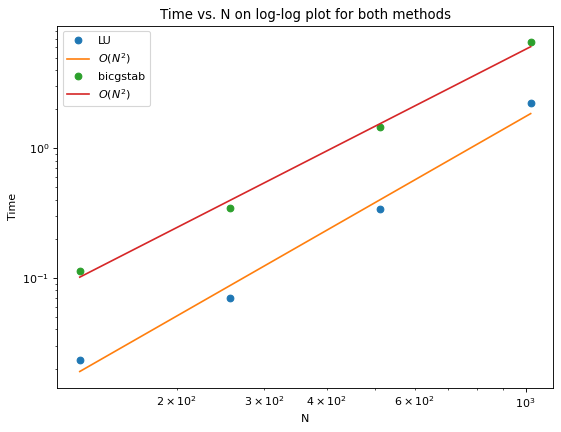

In [39]:
plt.figure(figsize=(8, 6), dpi=80)
plt.loglog(n, time_LU, 'o', label='LU')
plt.loglog(n, (n**slope_LU)*np.exp(intercept_LU), label='$O(N^2)$')
plt.loglog(n, time_bicg, 'o', label='bicgstab')
plt.loglog(n, (n**slope_bicg)*np.exp(intercept_bicg), label='$O(N^2)$')
plt.xlabel('N')
plt.ylabel('Time')
plt.title('Time vs. N on log-log plot for both methods')
plt.legend()
plt.savefig('Time_loglog_plot.png')
plt.show()

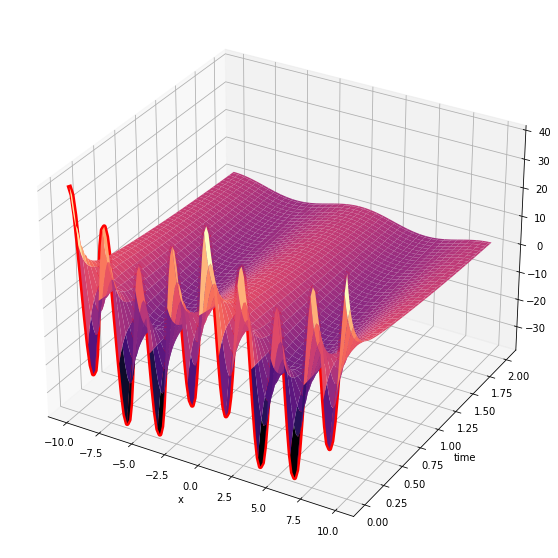

In [41]:
Time = 2
L = 10
n = 128
x2 = np.linspace(-L,L,n+1)
x = x2[0:n] #periodicity
dx = x[1] - x[0]

#time
t = np.linspace(0, 2, 501)
dt = t[1] - t[0]
time_steps = int(Time/dt)

# CFL number
CFL = 2*dt/(dx**2)
L_star = CFL
X, T = np.meshgrid(x,t)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize =(25, 10))
surf = ax.plot_surface(X, T, usol_fe.T,cmap='magma')
ax.plot3D(x, 0*x, 10*np.cos(2*np.pi*x/L)+30*np.cos(8*np.pi*x/L),'-r',linewidth=5)
plt.xlabel('x')
plt.ylabel('time')
plt.show()